# Time Scaling Plots

In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
from utils_reboot.datasets import Dataset
from utils_reboot.utils import * 
import os
import numpy as np
import pickle
import time
from matplotlib.ticker import AutoLocator, ScalarFormatter

2024-09-03 18:11:28.786967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utility Functions

In [5]:
last_shap_time=444854.5425505638+4000
last_shap_dict={'importances_time':last_shap_time}
basepath=os.path.dirname(os.getcwd())
last_shap_path=os.path.join(basepath,'experiments','results',
                            'Xaxis_100000_6','experiments','time_scaling','EIF+','KernelSHAP')
save_element(last_shap_dict,last_shap_path)

In [4]:
shap_path='/home/davide_frizzo/ExIFFI/experiments/results/Xaxis_25000_6/experiments/time_scaling/EIF+/KernelSHAP'
shap_dict=open_element(get_most_recent_file(shap_path))
shap_dict

{'importances_time': 28555.148218631744}

In [2]:
def get_shap_times(basepath,dataset_name):
    
    ts_shap_path=os.path.join(basepath,'experiments','results',
                              dataset_name,'experiments','time_scaling','EIF+',
                              'KernelSHAP')
    try:
        ts_shap_dict_path=get_most_recent_file(ts_shap_path)
    except FileNotFoundError:
        print('Dataset not found, KernelSHAP times not available')
        return None
    ts_shap_dict=open_element(ts_shap_dict_path)
    return ts_shap_dict['importances_time']

In [6]:
def get_vals(basepath,
             model, 
             dataset_names,
             type='predict',
             dict_name='time_scaling_test_shap.pickle'):
    
    with open(basepath + "/utils_reboot/" + dict_name, "rb") as file:
        dict_time = pickle.load(file)

    val_times=[]
    for d_name in dataset_names:
        time=np.array(dict_time[type][model][d_name])
        val_times.append(time)

    median_val_times=[np.percentile(x,50) for x in val_times]
    five_val_times=[np.percentile(x,5) for x in val_times]
    ninefive_val_times=[np.percentile(x,95) for x in val_times]

    return median_val_times,five_val_times,ninefive_val_times

In [7]:
def plot_time_scaling1(basepath,
                      model_names,
                      dataset_names,
                      data_path,
                      type='predict',
                      plot_type='samples',
                      plot_path=os.getcwd(),
                      show_plot=True,
                      save_plot=True,
                      dict_name:str='time_scaling_test_shap.pickle'):

    assert type in ['predict','fit','importances'], "Type not valid. Accepted values: ['predict','fit','importances'] "
    assert plot_type in ['samples','features'], "Plot Type not valid. Accepted values: ['samples','features']"
    
    datasets=[Dataset(name,path=data_path) for name in dataset_names]

    if plot_type == "samples":
        sample_sizes=[data.shape[0] for data in datasets]
    elif plot_type == "features":
        sample_sizes=[data.shape[1] for data in datasets]

    fig, ax = plt.subplots()
    plt.style.use('default')
    plt.rcParams['axes.facecolor'] = '#F2F2F2'
    plt.grid(alpha = 0.7)
    colors = ["tab:red","tab:blue","tab:orange","tab:green","tab:purple","tab:brown"]

    maxs=[]
    mins=[]
    for i,model in enumerate(model_names):
        median_times,five_times,ninefive_times=get_vals(basepath=basepath,
                                                        model=model,
                                                        dataset_names=dataset_names,
                                                        type=type,
                                                        dict_name=dict_name)
        maxs.append(np.max(median_times))
        mins.append(np.min(median_times))

        if model == 'sklearn_IF':
            ax.plot(sample_sizes,median_times,alpha=0.85,c=colors[i],marker="o",label='IF')
        else:
            ax.plot(sample_sizes,median_times,alpha=0.85,c=colors[i],marker="o",label=model)
        
        ax.fill_between(sample_sizes,five_times,ninefive_times,alpha=0.1,color=colors[i])
    
    if plot_type == "samples":
        ax.set_yscale('log')
        ax.set_xscale("log")
        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.minorticks_off()
        ax.set_xticks(sample_sizes,sample_sizes,rotation=45)
        ax.tick_params(axis='x',which='minor',labelsize=12)
        ax.set_yticks([1,10,25,100,250])
        ax.tick_params(axis='y',which='minor',labelsize=14)
    else:
        ax.set_xscale("log",base=2)
        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.minorticks_off()
        ax.set_xticks(sample_sizes,sample_sizes,rotation=45)
        ax.tick_params(axis='x',which='minor',labelsize=12)
        if type=='predict':
            ax.set_yticks([0.02,0.5,1,2,5,10])
        elif type=='fit':
            ax.set_yticks([0.06,3,8,15,30])
        elif type=='importances':
            ax.set_yticks([0.35,10,20,40,50,75,150,280])
        ax.tick_params(axis='y',which='minor',labelsize=14)

    if plot_type == "samples":
        ax.set_xlabel('Sample Size',fontsize = 20)
    elif plot_type == "features":
        ax.set_xlabel('N. Features',fontsize = 20)
    ax.set_ylabel(f'{type} Time (s)',fontsize = 20)
    #plt.ylim(np.min(mins)-0.2*np.min(mins),np.max(maxs)+0.2*np.max(maxs))

    ax.legend()
    ax.grid(visible=True, alpha=0.5, which='major', color='gray', linestyle='-')
    
    t = time.localtime()
    current_time = time.strftime("%d-%m-%Y_%H-%M-%S", t)

    if save_plot:
        plt.savefig(f'{plot_path}/{current_time}_time_scaling_plot_{plot_type}_{type}.pdf',bbox_inches='tight')

    if show_plot:
        plt.show()
    
    return fig,ax

## Time Scaling Dictionary

In [16]:
basepath=os.path.dirname(os.getcwd())
ts_path=os.path.join(basepath,'utils_reboot','time_scaling_test_acq2.pickle')
ts_dict=open_element(ts_path)
ts_dict.keys()

dict_keys(['fit', 'predict', 'importances'])

## Obtain Time Scaling Plots

In [20]:
model_names=['EIF+','EIF','sklearn_IF','DIF','AnomalyAutoencoder','ECOD']
model_names_importances=['EXIFFI+','EXIFFI','DIFFI','RandomForest','KernelSHAP']
dataset_names_samples=["Xaxis_100_6","Xaxis_250_6","Xaxis_500_6",
                       "Xaxis_2500_6","Xaxis_5000_6","Xaxis_10000_6",
                       "Xaxis_25000_6","Xaxis_50000_6","Xaxis_100000_6"]
dataset_names_features=["Xaxis_5000_16","Xaxis_5000_32","Xaxis_5000_64",
                        "Xaxis_5000_128","Xaxis_5000_256","Xaxis_5000_512"]
datapath_samples=os.path.join(basepath,'data','syn')
datapath_features=os.path.join(basepath,'data','syn','syn_feat_gz')
plot_path_samples=os.path.join(basepath,'experiments','results','time_scaling_plots','samples')
plot_path_features=os.path.join(basepath,'experiments','results','time_scaling_plots','features')

In [11]:
ts_dict['importances']['KernelSHAP'].keys()

dict_keys(['Xaxis_100_6', 'Xaxis_250_6', 'Xaxis_500_6', 'Xaxis_1000_6', 'Xaxis_2500_6', 'Xaxis_5000_6', 'Xaxis_10000_6', 'Xaxis_25000_6', 'Xaxis_50000_6'])

In [17]:
ts_dict['importances']['KernelSHAP']['Xaxis_100000_6']

[448854.5425505638]

In [13]:
shap_time=get_shap_times(basepath,'Xaxis_100000_6')
ts_dict['importances']['KernelSHAP']['Xaxis_100000_6']=[]
ts_dict['importances']['KernelSHAP']['Xaxis_100000_6'].append(shap_time)

In [15]:
save_element(element=ts_dict,
             directory_path=os.path.join(basepath,'utils_reboot'),
             filename='time_scaling_test_acq2_1',
             no_time=True)

### `fit` plots

Samples

In this plot `ECOD` is much faster than all the other models but in the three biggest datasets it surpasses the isolation based models. In particular it seems that it scales more or less like `DIF` and `Autoencoder` as the size of the dataset grows while isolation based models stay more or less constant in time. 

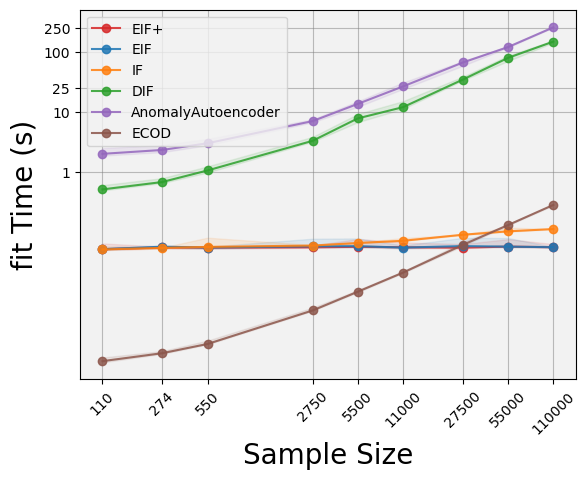

In [32]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names,
                         dataset_names=dataset_names_samples,
                         data_path=datapath_samples,
                         plot_path=plot_path_samples,
                         type="fit",
                         plot_type="samples",
                         show_plot=True,
                         save_plot=True,
                         dict_name='time_scaling_test_dei_new.pickle')

Features

Here `ECOD` has a very similar behavior to the one of `IF`, so it seems that increasing the number of features does not impact on its time complexity. Probably this happens because the univariate Anomaly Score computation is done in parallel on the different features

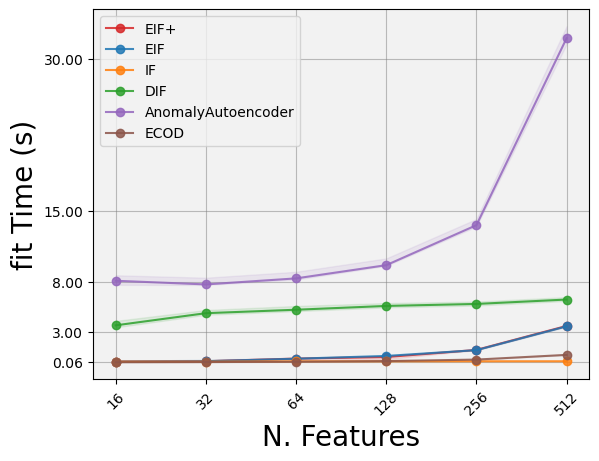

In [33]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names,
                         dataset_names=dataset_names_features,
                         data_path=datapath_features,
                         plot_path=plot_path_features,
                         type="fit",
                         plot_type="features",
                         show_plot=True,
                         save_plot=True,
                         dict_name='time_scaling_test_dei_new.pickle')

### `predict` plots

Samples

In this case `ECOD` is always the faster model although in the last datasets its computational times are coming very close to the ones of `IF`

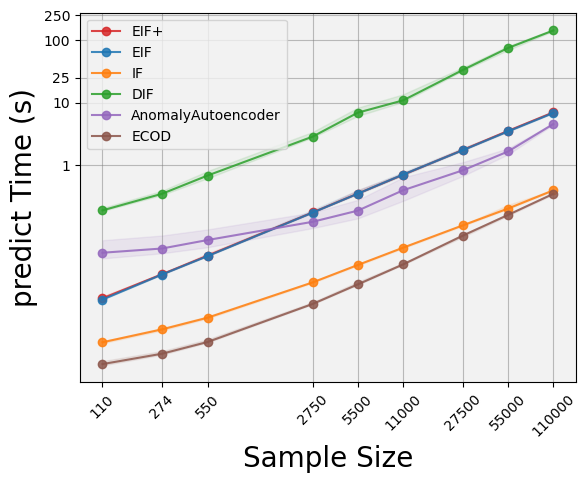

In [34]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names,
                         dataset_names=dataset_names_samples,
                         data_path=datapath_samples,
                         plot_path=plot_path_samples,
                         type="predict",
                         plot_type="samples",
                         show_plot=True,
                         save_plot=True,
                         dict_name='time_scaling_test_dei_new.pickle')

Features

`ECOD` has an almost constant prediction time as the number of features increases but we can notice a significant increase as we pass from 256 to 512 features. This is probably due to the fact that the model has to compute the Anomaly Score for each feature and then combine them up.

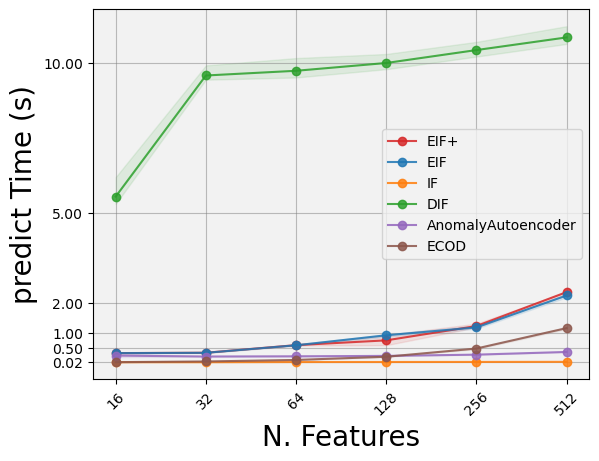

In [35]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names,
                         dataset_names=dataset_names_features,
                         data_path=datapath_features,
                         plot_path=plot_path_features,
                         type="predict",
                         plot_type="features",
                         show_plot=True,
                         save_plot=True,
                         dict_name='time_scaling_test_dei_new.pickle')

### `importances` plots

Samples

Here it is pretty clear that `KernelSHAP` is way out of scale with the respect to the other interpretation methods and a very similar results should be expected for the `features` plot. 

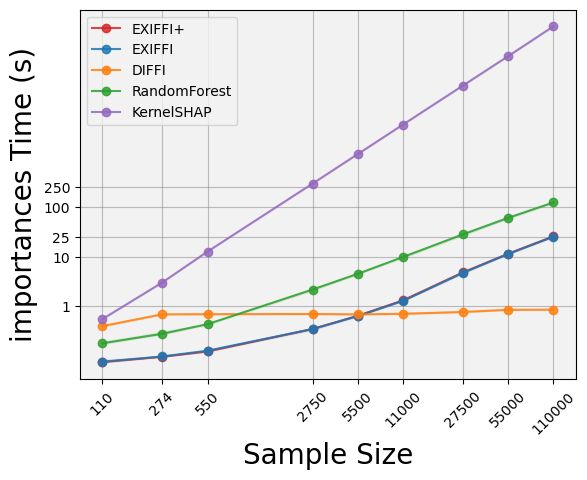

In [21]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names_importances,
                         dataset_names=dataset_names_samples,
                         data_path=datapath_samples,
                         plot_path=plot_path_samples,
                         type="importances",
                         plot_type="samples",
                         show_plot=True,
                         save_plot=False,
                         dict_name='time_scaling_test_acq2.pickle')

Features

In [ ]:
fig,ax=plot_time_scaling1(basepath=basepath,
                         model_names=model_names,
                         dataset_names=dataset_names_features,
                         data_path=datapath_features,
                         plot_path=plot_path_features,
                         type="importances",
                         plot_type="features",
                         show_plot=True,
                         save_plot=False,
                         dict_name='time_scaling_test_acq2.pickle')